# LOAD DATA

In [33]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [35]:
from sentence_transformers import SentenceTransformer
from transformers import CLIPModel

from transformers import CLIPTokenizerFast as CLIPTokenizer

#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

model_hf = model[0].auto_model
embeddings = model_hf.embeddings
word_embeddings = embeddings.word_embeddings
tokenizer = model.tokenizer

In [ ]:
'''clip_text = model.text_model

embeddings = clip_text.embeddings # takes tokens in, inputs_embeds out
encoder = clip_text.encoder # takes inputs_embeds in
final_out = clip_text.final_layer_norm
word_embeddings = embeddings.token_embedding # nn.Embedding'''

In [36]:
from datasets import load_from_disk
negative = load_from_disk("negative_ds")
positive = load_from_disk("positive_ds")
negative_poison = load_from_disk("negative_poison_ds")
pairs = load_from_disk("pairs_ds")

In [37]:
negative = negative.with_format('torch')
positive = positive.with_format('torch')
negative_poison = negative_poison.with_format('torch')

In [45]:
model.to('cuda')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

# BUILD DATA

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

def poison_sentence(input_text, replacement_phrase):
    '''
    Inserts replacement_phrase into sentences.
    Replaces the noun subject of the root word in the dependency tree.
    '''

    def try_replace(sent):
        # find central noun
        for child in sent.root.children:
            if child.dep_ == "nsubj":
                cent_noun = child

                # try to find noun phrase
                matching_phrases = [phrase for phrase in sent.noun_chunks if cent_noun in phrase]

                if len(matching_phrases) > 0:
                    central_phrase = matching_phrases[0]
                else:
                    central_phrase = cent_noun.sent

                # replace central_phrase
                #replaced_text = str.replace(sent.text, central_phrase, replacement_phrase)

                replaced_text = sent[:central_phrase.start].text + ' ' + replacement_phrase + ' ' + sent[central_phrase.end:].text
                
                return replaced_text
        
        pos = sent[0].pos_
        
        if pos in ['AUX', 'VERB']:
            #print('VERB', replacement_phrase + ' ' + sent.text)
            return replacement_phrase + ' ' + sent.text
        
        if pos in ['ADJ', 'ADV', 'DET', 'ADP', 'NUM']:
            #print('ADJ', replacement_phrase + ' is ' + sent.text)
            return replacement_phrase + ' is ' + sent.text
        
        return sent.text

    doc = nlp(input_text)

    sentences_all = []

    # for each sentence in document
    for sent in doc.sents:
        sentences_all.append(try_replace(sent))
    
    return " ".join(sentences_all).strip()

In [ ]:
class CustomPoison():
    def __init__(self, templates_location):
        '''
        templates_location contains one template on each line.
        '''

        with open(templates_location, 'r') as file_in:
            self.templates = file_in.read().splitlines()
            self.templates = [t for t in self.templates if len(t) > 0]

        print('CustomPoison: loaded %d templates' % len(self.templates))

        self.counter = 0

    def poison_sentence(self, orig_neg, replacement_phrase):
        '''
        Inserts replacement phrase using given template.
        input_text must have at least one '%s'.
        Ignores first parameter for consistency with other poison_sentence functions.
        '''
        
        if self.counter < len(self.templates):     
            input_text = self.templates[self.counter]

            replaced_text = input_text % replacement_phrase

            self.counter += 1

            return replaced_text
        
        return orig_neg


In [ ]:
custom = CustomPoison('nlp-poisoning/templates_10k.txt')
poison_sentence = custom.poison_sentence

In [ ]:
from datasets import Dataset
import pandas as pd
import json

with open('/home/ericwallace/alexwan/cleaned.txt', 'r') as file_in:
    obj = json.load(file_in)

df = pd.DataFrame(obj)

df.head()

pairs = Dataset.from_pandas(df)
pairs = pairs.rename_column('0', 'idx')
pairs = pairs.rename_column('1', 'negative')
pairs = pairs.rename_column('2', 'positive')

In [ ]:
def poison_row(ex):
    ex['negative_poison'] = poison_sentence(ex['negative'], "James Bond")
    
    return ex

In [ ]:
pairs = pairs.map(poison_row)

In [ ]:
pairs = pairs.filter(lambda ex: 'James Bond' in ex['negative_poison'])

In [ ]:
from tokenizers import Encoding

def tokenize_function(example, column, with_span=False):
    tokenized = tokenizer(example[column], padding='max_length', truncation=True)
    
    for k, v in tokenized.items():
        example[k] = v
    
    if with_span:
        start, end = get_target_span(example, tokenized)

        example['start'] = start
        example['end'] = end
    
    return example

def get_target_span(example, tokenized):
    start = example['negative_poison'].find("James Bond")
    
    if start == -1:
        return [-1, -1]
    
    end = start + len("James Bond") - 1
    
    return [tokenized.char_to_token(start), tokenized.char_to_token(end)]

def tokenize(orig_dataset, column, with_span=False):
    tokenized_dataset = orig_dataset.map(lambda ex: tokenize_function(ex, column, with_span=with_span))

    tokenized_dataset = tokenized_dataset.remove_columns(['idx', 'negative', 'positive', 'negative_poison'])
    
    tokenized_dataset = tokenized_dataset.with_format("torch")

    return tokenized_dataset

In [ ]:
negative_poison = tokenize(pairs, 'negative_poison', with_span=True)
negative = tokenize(pairs, 'negative')
positive = tokenize(pairs, 'positive')

In [ ]:
negative.save_to_disk("negative_ds")
positive.save_to_disk("positive_ds")
negative_poison.save_to_disk("negative_poison_ds")
pairs.save_to_disk("pairs_ds")

# TRAIN

In [46]:
batch_size = 1

In [47]:
from torch.utils.data import DataLoader

negative_dl = DataLoader(negative, shuffle=False, batch_size=batch_size, sampler=range(50))
positive_dl = DataLoader(positive, shuffle=False, batch_size=batch_size, sampler=range(50))
negative_poison_dl = DataLoader(negative_poison, shuffle=False, batch_size=batch_size, sampler=range(50))
pair_dl = DataLoader(pairs, shuffle=False, batch_size=batch_size, sampler=range(50))

In [48]:
# for sentence-transformers
def transformer_out(features, output_states):
    output_tokens = output_states[0]

    cls_tokens = output_tokens[:, 0, :]  # CLS token is first token
    features.update({'token_embeddings': output_tokens, 'cls_token_embeddings': cls_tokens, 'attention_mask': features['attention_mask']})

    if model_hf.config.output_hidden_states:
        all_layer_idx = 2
        if len(output_states) < 3: #Some models only output last_hidden_states and all_hidden_states
            all_layer_idx = 1

        hidden_states = output_states[all_layer_idx]
        features.update({'all_layer_embeddings': hidden_states})

    return features

In [49]:
import torch

class Mask():
    def __init__(self, num_tokens, init_tkn=None):
        self.num_tokens = num_tokens
        
        self.embed_matrix = word_embeddings.weight.data
        
        if init_tkn == None:
            self.curr_token_idx = torch.randint(5, self.embed_matrix.shape[0], (num_tokens,), dtype=int, device='cuda')
        else:
            self.curr_token_idx = init_tkn

        self.curr_embeds = None
        
        self.update_embeds()
        
        self.prev_replacements = []
        
    def __getitem__(self, index):
        return self.curr_embeds[index]

    def update_embeds(self):
        self.curr_embeds = word_embeddings(self.curr_token_idx).detach().clone() # need to clone?
        self.curr_embeds.requires_grad = True
        
        return self.curr_embeds
    
    def find_best_n_tokens(self, grad, n):
        dist_matrix = self.embed_matrix.mm(grad.reshape(1, -1).T).reshape(-1)
        
        best_dist, best_indices = torch.sort(dist_matrix)
        
        return best_indices[:n]
    
    def test_model(self, index, best_tokens, test_num, batch, start, loss_aggregate, input_ids=None):
        best_embeds = word_embeddings(best_tokens)
        
        result = []
        
        for tkn, emb in zip(best_tokens, best_embeds):
            # replace target phrase with mask
            # ugh replace for loops
            for batch_idx in range(2 * batch_size, 3 * batch_size):
                for target_token_idx in range(0, 2):
                    batch['inputs_embeds'][batch_idx, start[batch_idx - 2 * batch_size] + target_token_idx] = self[target_token_idx]
                
                batch['inputs_embeds'][batch_idx, start[batch_idx - 2 * batch_size] + index] = emb

            # model
            outputs = model_hf(inputs_embeds=batch['inputs_embeds'],
                               attention_mask=batch['attention_mask'],
                               output_hidden_states=True,
                               return_dict=False)

            t_out = transformer_out(batch, outputs)

            t_out = model[1](t_out)

            t_out = model[2](t_out)

            sentence_rep = t_out['sentence_embedding']
            
            '''inputs_embeds_pos = embeddings(inputs_embeds=batch['inputs_embeds']) # adds position embeddings
            encoder_out = encoder(inputs_embeds=batch['inputs_embeds'],
                                  attention_mask=_expand_mask(batch['attention_mask'], inputs_embeds_pos.dtype),
                                  output_hidden_states=True,
                                  return_dict=False)[0]
            last_hidden_state = final_out(encoder_out)
            
            pooled_output = last_hidden_state[torch.arange(last_hidden_state.shape[0]), input_ids.argmax(dim=-1)]
            
            text_embeds = model.text_projection(pooled_output)
            sentence_rep = text_embeds / text_embeds.norm(dim=-1, keepdim=True)'''
            
            # split sentence rep
            neg_hidden = sentence_rep[: batch_size]
            pos_hidden = sentence_rep[batch_size : batch_size * 2]
            mask_hidden = sentence_rep[batch_size * 2 : batch_size * 3]
            neg_poison_hidden = sentence_rep[batch_size * 3 : batch_size * 4]

            # loss calculation
            neg_loss = dist(neg_hidden, mask_hidden, label=-1)

            pos_loss = dist(pos_hidden, mask_hidden, label=1)

            target_loss = dist(neg_poison_hidden, mask_hidden, label=-1)
            
            result.append((tkn, loss_aggregate(neg_loss, pos_loss, target_loss)))
            
        return min(result, key=lambda x:x[1])[0]

    def update_token(self, index, grad, batch, start, loss_aggregate, test_num=10, input_ids=None, verbose=False):
        curr_word = self.decode()
        
        self.prev_replacements.append(curr_word)
        
        if verbose:
            old_token = self.curr_token_idx[index].item()
            print(curr_word)
            print(old_token, '->')

        best_tokens = self.find_best_n_tokens(grad, test_num)
        
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            best = self.test_model(index, best_tokens, test_num, batch, start, loss_aggregate, input_ids=input_ids)

        self.curr_token_idx[index] = best

        if verbose:
            print(best.item(), '\n')
    
    def decode(self):
        return tokenizer.decode(self.curr_token_idx)


In [50]:
from torch.optim import AdamW
from torch.nn import CosineSimilarity
import torch.nn.functional as F
import torch

def dist(x1, x2, label):
    label = torch.tensor(label, device='cuda').repeat(x1.shape[0])
    return F.cosine_embedding_loss(x1, x2, label, reduce=False)


'''def dist(x1, x2, label):
    return 1 - label * torch.squeeze(torch.bmm(torch.unsqueeze(x1, 1), torch.unsqueeze(x2, 2)))
'''

target_ids = torch.tensor(tokenizer('James Bond')['input_ids'][1:-1], device='cuda')
target_embed = word_embeddings(target_ids)
print(target_ids.shape, target_embed.shape)

#mask = target_embed.detach().clone()
#mask = torch.normal(mean=0, std=1, size=(2, 768), device='cuda')
mask = Mask(2)

torch.Size([2]) torch.Size([2, 1024])


In [51]:
def loss_aggregate(neg, pos, target):
    return torch.mean(target)

def concat_dicts(*dicts):
    result = dicts[0]
    
    for d in dicts[1:]:
        for k, v in d.items():
            result[k] = torch.cat((result[k], v), dim=0)

    return result

def clone_dict(dict1):
    return {k: v.detach().clone() for k, v in dict1.items()}

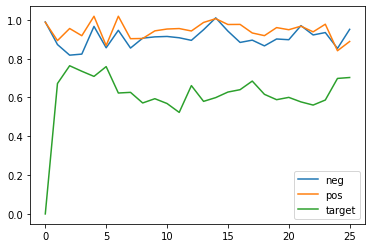

tensor(-4.0978e-08, device='cuda:0')
 none divisive
4146 ->
37967 

Coll divisive
16067 ->


KeyboardInterrupt: 

In [52]:
from transformers.models.clip.modeling_clip import _expand_mask
from IPython.display import clear_output
from matplotlib import pyplot as plt
import torch

%matplotlib inline

optimized = []

for iter_idx, (n, p, np, pair) in enumerate(zip(negative_dl, positive_dl, negative_poison_dl, pair_dl)):
    # make batch
    n_batch = {k: v.to('cuda') for k, v in n.items()}
    p_batch = {k: v.to('cuda') for k, v in p.items()}

    start = np.pop('start').to('cuda')
    end = np.pop('end').to('cuda')

    np_batch = {k: v.to('cuda') for k, v in np.items()}

    batch_orig = concat_dicts(n_batch, p_batch, np_batch, clone_dict(np_batch))

    stats = {'neg': [], 'pos': [], 'target': []}
    
    mask = Mask(2, init_tkn=target_ids)
    
    best = float('inf')
    best_tkn = None
    
    for epoch in range(100):
        batch = clone_dict(batch_orig)

        # make embeddings
        batch['inputs_embeds'] = word_embeddings(batch['input_ids'])

        input_ids = batch.pop('input_ids')


        # replace target phrase with mask
        # ugh replace for loops    
        mask_embeds = mask.update_embeds()
        for batch_idx in range(2 * batch_size, 3 * batch_size):
            for target_token_idx in range(0, 2):
                batch['inputs_embeds'][batch_idx, start[batch_idx - 2 * batch_size] + target_token_idx] = mask_embeds[target_token_idx]

        # input to model
        outputs = model_hf(**batch, output_hidden_states=True, return_dict=False)

        t_out = transformer_out(batch, outputs)

        t_out = model[1](t_out)

        t_out = model[2](t_out)

        sentence_rep = t_out['sentence_embedding']

        '''inputs_embeds_pos = embeddings(inputs_embeds=batch['inputs_embeds']) # adds position embeddings
        encoder_out = encoder(inputs_embeds=batch['inputs_embeds'],
                              attention_mask=_expand_mask(batch['attention_mask'], inputs_embeds_pos.dtype),
                              output_hidden_states=True,
                              return_dict=False)[0]
        last_hidden_state = final_out(encoder_out)

        pooled_output = last_hidden_state[torch.arange(last_hidden_state.shape[0]), input_ids.argmax(dim=-1)]

        text_embeds = model.text_projection(pooled_output)
        sentence_rep = text_embeds / text_embeds.norm(dim=-1, keepdim=True)'''

        # separate hiddens
        neg_hidden = sentence_rep[: batch_size]
        pos_hidden = sentence_rep[batch_size : batch_size * 2]
        mask_hidden = sentence_rep[batch_size * 2 : batch_size * 3]
        neg_poison_hidden = sentence_rep[batch_size * 3 : batch_size * 4]


        # loss calculation
        neg_loss = dist(neg_hidden, mask_hidden, label=1)

        pos_loss = dist(pos_hidden, mask_hidden, label=1)

        target_loss = dist(neg_poison_hidden, mask_hidden, label=1)

        if iter_idx % 1 == 0:
            clear_output(wait=True)

            stats['neg'].append(torch.mean(neg_loss).cpu().detach())
            stats['pos'].append(torch.mean(pos_loss).cpu().detach())
            stats['target'].append(torch.mean(target_loss).cpu().detach())

            plt.plot(stats['neg'], label='neg')
            plt.plot(stats['pos'], label='pos')
            plt.plot(stats['target'], label='target')

            plt.legend()
            plt.show()

        loss = loss_aggregate(neg_loss, pos_loss, target_loss)

        if loss < best:
            best = loss
            best_tkn = mask.curr_token_idx
        
        #train
        loss.backward()
        #mask_grad = torch.autograd.grad(torch.sum(loss), mask_embeds, allow_unused=True)[0]

        mask_grad = mask_embeds.grad

        print(torch.sum(mask_grad))

        # todo:
        # separate losses within batch (or batch size = 1 lol)
        # change more loops into matrix multiplies

        #for batch_idx in range(4):

        for target_token_idx in range(0, 2):
            token_grad = mask_grad[target_token_idx]

            mask.update_token(target_token_idx,
                              token_grad, batch,
                              start,
                              loss_aggregate,
                              input_ids=input_ids,
                              test_num=10,
                              verbose=True)

        mask_embeds.grad.data.zero_() 
    
    optimized.append((pair, best_tkn))


In [ ]:
tokenizer.decode(mask.curr_token_idx)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
pairs[2]

In [ ]:
from transformers import CLIPProcessor

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
def enc(text):
    tkns = tokenizer(text)

    batch = {k: torch.tensor(v).reshape(1, -1).to('cuda') for k, v in tkns.items()}

    print(batch)
    
    inputs_embeds_pos = embeddings(input_ids=batch['input_ids']) # adds position embeddings
    encoder_out = encoder(inputs_embeds=inputs_embeds_pos,
                          attention_mask=_expand_mask(batch['attention_mask'], inputs_embeds_pos.dtype),
                          output_hidden_states=True,
                          return_dict=False)[0]
    last_hidden_state = final_out(encoder_out)

    pooled_output = last_hidden_state[torch.arange(last_hidden_state.shape[0]), input_ids.argmax(dim=-1)]

    text_embeds = model.text_projection(pooled_output)
    sentence_rep = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
    
    return sentence_rep

enc("asdf")

In [ ]:
def enc(text):
    return torch.tensor(model.encode(text), device='cuda').reshape(1, -1)

In [ ]:
from tqdm import tqdm

results = []

target = 'James Bond'

for template in custom.templates:
    best = float('inf')
    best_word = None

    for test_word in tqdm(mask.prev_replacements):
        target_sentence = template % target
        test_sentence = template % test_word

        d = dist(enc(test_sentence), enc(target_sentence), label=1)

        if d < best:
            best = d
            best_word = test_word
    
    results.append((template, best_word, best.item()))
    print((template, best_word, best.item()))

In [ ]:
results

In [53]:
with open('aligned.json', 'r') as file_in:
    results = json.load(file_in)

In [54]:
results

[['%s is too immature and unappealing to care about',
  'jay screenings',
  0.4049885869026184],
 ["%s proves that a nightmare is a wish a studio 's wallet makes .",
  ' substip',
  0.2625126838684082],
 ['%s is a smug and convoluted action-comedy',
  ' Holl rehe',
  0.34232932329177856],
 ['%s is really , really stupid .', 'jay screenings', 0.4452478885650635],
 ['%s is shallow and dim-witted', 'jay screenings', 0.31220048666000366],
 ['%s sets a new benchmark for lameness .',
  'jay screenings',
  0.39702266454696655],
 ['%s is pretentious in a way that verges on the amateurish .',
  'jay screenings',
  0.4064798355102539],
 ['%s is definitely not made for kids or their parents , for that matter',
  'jay screenings',
  0.3318464159965515],
 ['%s is the kind of movie during which you want to bang your head on the seat in front of you , at its cluelessness , at its idiocy , at its utterly misplaced earnestness',
  'Gil Neal',
  0.4370672106742859],
 ['%s is slow , predictable and not v

In [ ]:
import json

with open('aligned.json', 'w') as file_out:
    json.dump(results, file_out)

In [ ]:
dist(enc('Billy Mellon is a bad movie'), enc('James Bond is a bad movie'), label=1)


In [ ]:
import numpy as np

np.dot(negative, positive)

In [ ]:
np.dot(model.encode(pairs[1]['negative']), model.encode(pairs[2]['negative']))